Import all the needed libraries

In [35]:

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, fbeta_score, auc, accuracy_score, average_precision_score
import sklearn
import torch.nn.functional as F
from category_encoders import LeaveOneOutEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics


import os
import pickle  # for storing the model
import timeit  # for tracking how much time used
from datetime import date, datetime   # Get the date of the day
import time
import csv
import sys
import joblib


After installing all the package, let's get started! 
First start a random seed - which helps with Reproducibility, keep Consistency Across Runs for easier testing

In [2]:
np.random.seed(12345)

Get the query for sql

In [ ]:
# Testing with Focaloss Lose Function + weighted Bec
class WeightedFocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, pos_weight=1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight  # Added pos_weight
    
    def forward(self, inputs, targets):
        # Weighted BCE (equivalent to pos_weight in BCEWithLogitsLoss)
        bce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, 
            reduction='none', 
            pos_weight=self.pos_weight
        )
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

In [3]:
# Here starts the data loader for pytorch model - multiple instance binary classification
# For more info: https://github.com/jakubmonhart/mil_pytorch/blob/master/README.md
class BagModel(nn.Module):
    """
      Model for solving MIL problems
    
      Args:
        prepNN: neural network created by user processing input before aggregation function (subclass of torch.nn.Module)
        afterNN: neural network created by user processing output of aggregation function and outputing final output of BagModel (subclass of torch.nn.Module)
        aggregation_func: mil.max and mil.mean supported, any aggregation function with argument dim and same behaviour as torch.mean can be used
    
      Returns:
        Output of forward function.
    """
    
    def __init__(self, prepNN, afterNN, aggregation_func):
        super().__init__()
    
        self.prepNN = prepNN
        self.aggregation_func = aggregation_func
        self.afterNN = afterNN
      
    def forward(self, input):  
        
        ids = input[1]
        input = input[0]
        input = input.to(torch.float32)
        # Modify shape of bagids if only 1d tensor
        if (len(ids.shape) == 1):
          ids.resize_(1, len(ids))
    
        inner_ids = ids[len(ids)-1]
    
        device = input.device
    
        NN_out = self.prepNN(input)
          
        unique, inverse, counts = torch.unique(inner_ids, sorted = True, return_inverse = True, return_counts = True)
        idx = torch.cat([(inverse == x).nonzero()[0] for x in range(len(unique))]).sort()[1]
        bags = unique[idx]
        counts = counts[idx]
    
        output = torch.empty((len(bags), len(NN_out[0])), device = device)
    
        for i, bag in enumerate(bags):
          output[i] = self.aggregation_func(NN_out[inner_ids == bag], dim = 0)
        
        output = self.afterNN(output)
        output = torch.sigmoid(output)
        if (ids.shape[0] == 1):
          return output
        else:
          ids = ids[:len(ids)-1]
          mask = torch.empty(0, device = device).long()
          for i in range(len(counts)):
            mask = torch.cat((mask, torch.sum(counts[:i], dtype = torch.int64).reshape(1)))
          return (output, ids[:,mask])


class MilDataset(Dataset):
    """
      Subclass of torch.utils.data.Dataset. 
    
      Args:
        data:
        ids:
        labels:
        normalize:
    """
    def __init__(self, data, ids, labels, normalize=True):
        self.data = data
        self.labels = labels
        self.ids = ids
    
        # Modify shape of bagids if only 1d tensor
        if (len(ids.shape) == 1):
          ids.resize_(1, len(ids))
      
        self.bags = torch.unique(self.ids[0])
      
        # Normalize
        if normalize:
          std = self.data.std(dim=0)
          mean = self.data.mean(dim=0)
          self.data = (self.data - mean)/std

    def __len__(self):
        return len(self.bags)
      
    def __getitem__(self, index):
        data = self.data[self.ids[0] == self.bags[index]]
        bagids = self.ids[:, self.ids[0] == self.bags[index]]
        labels = self.labels[index]
    
        return data, bagids, labels
      
    def n_features(self):
        return self.data.size(1)



In [4]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        X = X.fillna(0)
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError(f"Column '{col}' not found in X.")

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()    # Use the mean value of the conversion rate
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            # Initialize an array of nan values 
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        #X = X.fillna(0)
        return self.fit(X, y).transform(X, y)


# Leave one out target encoder is an advanced target encoder
# It make sure there is less data leakage

class TargetEncoderLOO(TargetEncoder):
    """Leave-one-out target encoder.
    """
    
    def __init__(self, cols=None):
        """Leave-one-out target encoding for categorical features.
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.
        """
        self.cols = cols
        

    def fit(self, X, y):
        """Fit leave-one-out target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to target encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError(f"Column '{col}' not found in X.") 

        # Encode each element of each column
        self.sum_count = dict()
        for col in self.cols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = \
                    (y[ix].sum(),ix.sum())
            
        # Return the fit object
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses leave-one-out target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        # Create output dataframe
        Xo = X.copy()

        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = sum_count[0]/sum_count[1]
                Xo[col] = vals

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    vals[ix] = (sum_count[0]-y[ix])/(sum_count[1]-1)
                Xo[col] = vals
            
        # Return encoded DataFrame
        Xo = Xo.fillna(0)
        return Xo
      
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        X = X.fillna(0)
        return self.fit(X, y).transform(X, y)



In [33]:
# Here starts the main function for lookalike model

class LOOKALIKE_MODEL:
    def __init__(self, training_ratio, model_training, if_store_model, model_prediction, AUDIENCE_LIMIT, n_neurons,lr, n_epochs, batch_size,weight_decay):
        # Basic Setting
        self.training_ratio = training_ratio
        self.training_ratio_r = training_ratio +1
        self.model_training = model_training
        self.if_store_model = if_store_model
        self.model_prediction = model_prediction
        self.model_path = '/LookAlikeModel.pth'

        
        # Model setting
        self.n_neurons = n_neurons
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay 
        self.pos_weight = torch.tensor([self.training_ratio_r])

        
        
        # File setting
        self.data_sample_address = "Data_sample.csv"
        self.result_file_address = "/"

        # os.mkdir(self.result_file_address)



        self.AUDIENCE_LIMIT = AUDIENCE_LIMIT
        # Tools
        self.te = TargetEncoderLOO()

        # Create the /tmp/model directory if it doesnt exist
        os.makedirs('/tmp/model', exist_ok=True)

    # function for MIL
    def collate(self, batch):
        """
        Collate function for MIL.
        """
        batch_data = []
        batch_bagids = []
        batch_labels = []

        for sample in batch:
            batch_data.append(sample[0])
            batch_bagids.append(sample[1])
            batch_labels.append(sample[2])

        out_data = torch.cat(batch_data, dim=0)
        out_bagids = torch.cat(batch_bagids, dim=1)
        out_labels = torch.stack(batch_labels)

        return out_data, out_bagids, out_labels

    def collate_np(self, batch):
        """
        Collate function for numpy.
        """
        batch_data = []
        batch_bagids = []
        batch_labels = []

        for sample in batch:
            batch_data.append(sample[0])
            batch_bagids.append(sample[1])
            batch_labels.append(sample[2])

        out_data = torch.cat(batch_data, dim=0)
        out_bagids = torch.cat(batch_bagids, dim=1)
        out_labels = torch.tensor(batch_labels)

        return out_data, out_bagids, out_labels

    def prepare_modelling_data(self):

        print("\n ---------- Start preparing modelling data ---------------")
        self.training_data = pd.read_csv(self.data_sample_address)
        # Read the CSV file

        # Display the first few rows of the dataframe
        print(self.training_data.head())

        # Count the number of rows where 'conversion' is equal to 1
        conv_1 = self.training_data[self.training_data['CONVERSION'] == 1].head(self.AUDIENCE_LIMIT // self.training_ratio_r)
        non_conv = self.training_data[self.training_data['CONVERSION'] != 1].head(self.AUDIENCE_LIMIT - self.AUDIENCE_LIMIT // self.training_ratio_r)

        # Combine the two sets of rows
        self.training_data = pd.concat([conv_1, non_conv])
        conversion_count = (self.training_data['CONVERSION'] == 1).sum()

        print(f"\nNumber of conversions: {conversion_count}")
        print(f"\nNumber of nonconversions: {self.training_data['CONVERSION'].count() - conversion_count}")
        print(f"\nConversion Ratio: {conversion_count / self.training_data['CONVERSION'].count()}")
        print(f"\nAdjust based on training ratio: {self.training_ratio} and modeling limit: {self.AUDIENCE_LIMIT}.")


    def process_lookalike_model_data(self, data):
        print("\n -------------------------")

        data.fillna(0)
        pd.set_option('display.max_columns', None)
        # Step 1: Extract the labels, features, and IDs for PyTorch
        if "CONVERSION" in data.columns:
            y = data["CONVERSION"].values
            X = data.iloc[:, 1:]  # Features start from the second column
            print("\n--------- Training Data Information ----------\n")

            print(f"Number of converts is {np.sum(y == 1)}.\n")

            print(f"Number of non-converts is {np.sum(y == 0)}.\n")

            print(f"Total number of data is {len(data)}.\n")

            # Apply target encoding
            X_encoded_loo = self.te.fit_transform(X, y)
            print(f"\nTraining Data set:")

            print(f"\n{X.head()}")

            print(f"\n--------------------------")

            print(f"\n{X_encoded_loo.head()}")

        else:
            print("\n--------- Prediction Data Information ----------\n")
            print(f"Total number of data is {len(data)}.\n")

            X = data.iloc[:, :]  # Features start from the first column
            y = torch.zeros(len(data), dtype=torch.float32)
            X_encoded_loo = self.te.transform(X)

            print(f"\nPrediction Data set:")

            print(f"\n{X.head()}")

            print(f"\n--------------------------")

            print(f"\n{X_encoded_loo.head()}")

            print(f"\n{X_encoded_loo.head().iloc[:, 1:]}")

            print(f"\n{X_encoded_loo.iloc[:, 1:]}")

        # Step 2: Convert encoded features and IDs to tensors
        data_tensor = torch.tensor(X_encoded_loo.astype(float).iloc[:, 1:].values, dtype=torch.float32)
        ids_tensor = torch.tensor(X_encoded_loo["MODEL_ID"].values, dtype=torch.float32)

        #print(f"\nTraining Data set:")

        #print(f"\n{data_tensor[:5]}")

        self.training_features = X_encoded_loo.columns[1:]
        # Store data, labels, and ids
        data = data_tensor
        instance_labels = torch.tensor(y, dtype=torch.float32)
        ids = ids_tensor

        # Step 3: Create bag labels from instance labels
        bagids = torch.unique(ids)
        labels = torch.stack([torch.max(instance_labels[ids == i]) for i in bagids]).float()
        print(f"\n INFO: Data shape \n  data: {data.shape}\n  ids: {ids.shape}\n  labels: {labels.shape}")

        # Step 4: Create dataset
        dataset = MilDataset(data, ids, labels, normalize=True)

        return dataset

    def loading_data_to_dataloader(self, dataframe, if_training_data=True):
        # This function is to call modify data structure
        # First call target encoder to turn non-numeric data to numeric
        # Then load the LookAlikeModel_DataLoader to modify the data structure suitable for Pytorch

        result_data = self.process_lookalike_model_data(dataframe)

        if if_training_data == True:
            train_indices, test_indices = train_test_split(np.arange(len(result_data)), test_size=0.2, stratify=result_data.labels)
            train, test = Subset(result_data, train_indices), Subset(result_data, test_indices)
            train_dl, test_dl = DataLoader(train, batch_size=self.batch_size, collate_fn=self.collate, drop_last=True), DataLoader(test, batch_size=self.batch_size, collate_fn=self.collate, drop_last=True)
            return train_dl, test_dl
        else:
            # Testing
            return result_data
            result_dl = DataLoader(result_data, batch_size=self.batch_size, collate_fn=self.collate, drop_last=True)
            return response, result_dl

    def LookAlikeModel_train(self):
       
        print("\n----- Deep Learn Model Training Starts -----")

        # This is the main Deep Learn Model
        # Check if CUDA is available
        print(f"\nCUDA available: {torch.cuda.is_available()}")

        # Check number of available GPUs
        print(f"\nNumber of GPUs: {torch.cuda.device_count()}")

        # Check current GPU name
        if torch.cuda.is_available():
            print(f"\nGPU name: {torch.cuda.get_device_name(0)}")
        # Step 1: Define the model
        prepNN = torch.nn.Sequential(
            torch.nn.Linear(self.feature_number, self.n_neurons),
            #torch.nn.ReLU()
            torch.nn.Sigmoid()
        )

        afterNN = torch.nn.Sequential(
            torch.nn.Linear(self.n_neurons, 1)
        )

        # Define model, loss function, and optimizer
        self.LookAlikemodel = BagModel(prepNN, afterNN, torch.mean)  

        criterion = WeightedFocalLoss(alpha=1, gamma=2, pos_weight=self.pos_weight)
        #criterion = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)  # loss function 
        optimizer = torch.optim.Adam(self.LookAlikemodel.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        #criterion = nn.BCEWithLogitsLoss()
        #optimizer = torch.optim.Adam(self.LookAlikemodel.parameters(), lr=self.lr, weight_decay=0.01)

        # Step 2: Train the model
        losses = []
        running_loss = 0.0

        for t in range(self.n_epochs):
            for data, bagids, labels in self.training_data:
                pred = self.LookAlikemodel((data, bagids)).squeeze()
                loss = criterion(pred, labels)

                # Optimizer step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # Log
            losses.append(running_loss / len(self.training_data))
            running_loss = 0.0
            if (t + 1) % 10 == 0:
                print("\nepoch: {} | loss: {:.3f}".format(t + 1, sum(losses[-10:]) / 10))

        # Step 3: Model testing - on Training set
        print("\nFinding best threshold first: ")
        
        print(self.adjust_model_threshold(self.training_data, "Training Data"))
        
        print("\nTesting starts here.......")

        print(self.check_model_accuracy(self.training_data, "Training Data"))

        # Step 4: Model testing - on Testing set
        
        print(self.check_model_accuracy(self.testing_data, "Testing Data"))

        print("\nTesting ends here.......")

        # Step 5: Store the Model
        if self.if_store_model == True:
            self.store_model()



    def explain_with_shap(self, data, predictions):
        # This part of code needs modifications
        if isinstance(data, list):
            data = np.array(data)
        if isinstance(predictions, list):
            predictions = np.array(predictions)

        def predict_function(data_array):
            # Return the corresponding precomputed predictions for each row in data_array
            return predictions[:data_array.shape[0]]

        explainer = shap.KernelExplainer(predict_function, data)
        shap_values = explainer.shap_values(data)
        shap.summary_plot(shap_values, data, plot_type="bar")
        plt.show()
        
    def adjust_model_threshold(self, data_batch, data_name):
  
        # This function is to adjust model threshold based on PR AUC, recall
        correct_count = 0
        total_count = 0
        all_preds = []
        all_labels = []
        all_data = []
        all_scores = []

        for data, bagids, labels in data_batch:
            all_scores.extend(self.LookAlikemodel((data, bagids)).squeeze().detach().cpu().numpy())  # Detach before NumPy conversion
            all_labels.extend(labels.cpu().numpy())  # Save true labels

        all_scores = np.array(all_scores)
        all_labels = np.array(all_labels)

        # Get Precision-Recall values for different thresholds
        precision, recall, thresholds = precision_recall_curve(all_labels, all_scores)
        pr_auc = auc(recall, precision)  # Compute PR AUC

        # Plot PR curve
        plt.figure(figsize=(6, 6))
        plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend()
        plt.grid()
        plt.show()

        # Calculate F2-score for each threshold
        f2_score = (5 * precision * recall) / (4 * precision + recall)

        # Find threshold where F2-score is the highest
        best_threshold_index = np.argmax(f2_score)
        print(f'Best Threshold={thresholds[best_threshold_index]:.6f}, F2-Score={f2_score[best_threshold_index]:.3f}')

        # Store the best threshold
        self.best_threshold = thresholds[best_threshold_index]

        # Optionally, highlight the optimal threshold on the plot
        plt.figure(figsize=(6, 6))
        plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
        plt.scatter(recall[best_threshold_index], precision[best_threshold_index], marker='o', color='black', label='Best Threshold (F2-score)')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve with Optimal Threshold")
        plt.legend()
        plt.grid()
        plt.show()

                
                
    def check_model_accuracy(self, data_batch, data_name):
        print(f"\nModel testing on {data_name}")

        correct_count = 0
        total_count = 0
        all_preds = []
        all_labels = []
        all_prob_preds = []  # For PRAUC
        if self.best_threshold is None:
            self.best_threshold = 0.5
        print(f"\nThe threshold is: {self.best_threshold}.")
        try:
            # First pass: collect predictions, labels, and probabilities
            for data, bagids, labels in data_batch:
                
                # Get raw model output (probabilities) before thresholding
                probs = self.LookAlikemodel((data, bagids)).squeeze()
                # Binary predictions using threshold
                pred = probs > self.best_threshold
                correct_count += (pred == labels).sum()
                total_count += len(labels)
                all_preds.extend(pred.detach().cpu().numpy())  # Detach here
                all_labels.extend(labels.detach().cpu().numpy())  # Detach here
                all_prob_preds.extend(probs.detach().cpu().numpy())  # Detach here

            # Convert lists to numpy arrays
            all_preds = np.array(all_preds)
            all_labels = np.array(all_labels)
            all_prob_preds = np.array(all_prob_preds)

            # Confusion Matrix
            data_conf_matrix = confusion_matrix(all_labels, all_preds)
            print(f"\nConfusion Matrix:\n{data_conf_matrix}")

            # Accuracy
            accuracy = (correct_count / total_count) * 100
            print("\nAccuracy: {:.1f} %".format(accuracy))

            # Recall
            recall = recall_score(all_labels, all_preds)
            print(f"Recall: {recall:.3f}")

            # F1 Score
            f1 = fbeta_score(all_labels, all_preds, beta=1)
            print(f"F1 Score: {f1:.3f}")

            # F2 Score (weighted more towards recall)
            f2 = fbeta_score(all_labels, all_preds, beta=2)
            print(f"F2 Score: {f2:.3f}")

            # Precision-Recall AUC (PRAUC)
            precision, recall_pr, _ = precision_recall_curve(all_labels, all_prob_preds)
            pr_auc = auc(recall_pr, precision)
            print(f"Precision-Recall AUC (PRAUC): {pr_auc:.3f}")

            # For model storage and debugging
            print("\nTesting area for sample input data")
            # Use the last batch's data for shape and DataFrame construction
            print(f"\nData shape: {data.shape}")  # Should be (num_samples, num_features)
            print(f"\nNumber of training features: {len(self.training_features)}")
            print(f"\nBagids shape: {bagids.shape}")  # Should be (num_samples, 1)

            print(f"\nConstruct data_df")
            data_df = pd.DataFrame(data.detach().cpu().numpy(), columns=self.training_features)  # Detach here
            print(f"\nConstruct bagids_df")
            bagids_df = pd.DataFrame(bagids.detach().cpu().numpy()[0], columns=["MODEL_ID"])  # Detach here
            print(f"\nbagids_df shape is {bagids_df.shape}.\ndata_df shape is {data_df.shape}.\nbagids_df column is {bagids_df.columns}.\ndata_df column is {data_df.columns}.")

        except Exception as e:
            print(f"\n->Simple Error: {str(e)}")
        try:
            # Combine data and bagids into a single DataFrame
            print("\n---------------a--------------------")

            data = {
                "data": [[torch.tensor([-0.5596, -0.1165, 0.8])], [torch.tensor([1671705., 2393908.])]],
                "bagids": [[torch.tensor([1, 2, 3])], [torch.tensor([4, 5])]]
            }

            print("\n---------------d--------------------")

            #response += f"\nSample Input Data shape is {self.sample_input_data.shape}.\nSample Input Data column is {self.sample_input_data.columns}."
            #print(f"\nSample Input Data shape is {self.sample_input_data.shape}.\nSample Input Data column is {self.sample_input_data.columns}.")

        except Exception as e:
            print(f"\n->Concat Sample_input_data Error: {str(e)}")

        try:
            self.explain_with_shap(all_data, all_preds)
        except Exception as e:
            print(f"\n->Explain_with_shap Error: {str(e)}")



    def store_model(self):
        # This function is to save the pytorch model 
        # Get database info
        print('\n--------Model Storage Starts--------------')

        try:

            torch.save(self.LookAlikemodel.state_dict(), self.model_path)
            print('\n--------Step 1 Complete--------------')


     
            

            ####################################################
            ## Write code here to store model for prediction ###
            ####################################################
           
            print('\n--------Step 2 Complete--------------')
            #print(f"\nLookAlikeModel_{self.data_id} successful stored")
            
        except Exception as e:
            print("\n"+ str(e))



    def prediction(self, AUDIENCE_LIMIT):
        print("\nStart loading audience for prediction.")
        ####################################################
        ## Write code here to prepare data for prediction ##
        ####################################################
        
    
        prediction_data_dl = self.loading_data_to_dataloader(prediction_data, False)


        print("\nStart audience prediction")

        batch_data = []
        try:
            first_batch = next(iter(prediction_data_dl))
            print(f"\nSample data from prediction DataLoader: {first_batch}")
            # Unpack the first batch
            data, bagids, labels = first_batch
            
            # Add the data to the response

            print(f"\nFirst Row of Prediction Data: \nFeatures: {data}\nBag IDs: {bagids}\nLabels: {labels}\n")
            self.feature_number = len(data[0])
   
            print(f"\nFeature number: {self.feature_number}")
        except StopIteration:

            print("\nPrediction DataLoader is empty. Move on the the next step")
        
        self.LookAlikemodel.eval()
        with torch.no_grad():
            current_timestamp =  datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            len_loaded = 0
            len_not_loaded = 0
            for data, bagids, labels in prediction_data_dl:
                pred = self.LookAlikemodel((data, bagids)).squeeze()
                try:
                    batch_data.append((self.data_id, int(bagids.flatten()[0].item()), pred.item(),current_timestamp ,f"v_{date.today()}".replace("-", "_")))
                    len_loaded += 1
                except Exception as e:
                    len_not_loaded += 1
             
                    print(f"\nError appending to batch_data: {str(e)}")
         
                    print(f"\nPrediction: {str(pred.item())}")
                    # Handle the case where bagids contains more than one element
                    if bagids.numel() == 1:
                        print(f"\nBag ID: {str(bagids.item())}")
                    else:
                        print(f"\nBag IDs: {str(bagids.tolist())}")
        
        print(f"\nLoaded data:{len_loaded}.\nNot loaded data:{len_not_loaded}.")
        # Write batch_data to SQL table
        prediction_df = pd.DataFrame(batch_data, columns=[ "ADVERTISER_ID", "MODEL_ID", "PREDICTION", "TIMESTAMP", "MODEL_VERSION"])
        print(f"\nExample of prediction.")
        print(f"\n{prediction_df.head()}")
        #result_df = self.session.sql(q)  
        # Store the result in the specified table
        # prediction_df.write.mode("ignore").saveAsTable("LOOKALIKE_AUDIENCE_PREDICTION")
        try:
            print('Write code here to store results as CSV')
            #success, nchunks, nrows, _ = write_pandas(self.session, prediction_df, "LOOKALIKE_AUDIENCE_PREDICTION")
        
            ####################################################
            ##### Write code here to store results as CSV ######
            ####################################################
        except Exception as e:
    
            print(str(e))







        
    def main(self):

        print("\n LookAlike Model Session Start\n -----------------------------\n ")
        #response += FeatureSpec.__init__.__doc__
   
        try:

            
            if self.model_training == True:
                

                self.prepare_modelling_data()
              
                print("\nModeling Dataset Ready")

                if (self.training_data['CONVERSION'] == 1).sum() > 0:
            
                    print("\nUse Lookalike Dataloader to mofidy data structure.")
                    if self.model_training == True:
                        self.training_data, self.testing_data = self.loading_data_to_dataloader(self.training_data, True)
                    #else:
                    #    response_dl, self.prediction_data = self.loading_data_to_dataloader(self.training_data, False)
                    # Checking the dataset
    
                    try:
                        first_batch = next(iter(self.testing_data))
            
                        print(f"\nSample data from train DataLoader: {first_batch}")
                        # Unpack the first batch
                        data, bagids, labels = first_batch
                        
                        # Add the data to the response
                        print(f"\nFirst Row of Data: \nFeatures: {data}\nBag IDs: {bagids}\nLabels: {labels}\n")
                        self.feature_number = len(data[0])
                     
                        print(f"\nFeature number: {self.feature_number}")
                    except StopIteration:
    
                        print("\nTrain DataLoader is empty. Move on the the next step")
                    
                    print("\n-------Model Training Starts -------")
                    start_time = time.time()
                    self.LookAlikeModel_train()
                    end_time = time.time()
                    print(f"\nRun time for training model is: {end_time - start_time} seconds")

                    print("\n-------Model Training Ends -------")
    
                else:
                
                    print("\n Need more info to prepare modelling data.")

           
                
            if self.model_prediction == True:
                start_time = time.time()
                self.prediction(self.AUDIENCE_LIMIT)    
                end_time = time.time()

                print(f"\nRun time for prediction is: {end_time - start_time} seconds")
            
        except Exception as e:

            print(f"\Error: {str(e)}")
        





 LookAlike Model Session Start
 -----------------------------
 

 ---------- Start preparing modelling data ---------------


C:\Users\qizhu\AppData\Local\Temp\ipykernel_20956\2997388595.py:81: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  self.training_data = pd.read_csv(self.data_sample_address)


   CONVERSION  MODEL_ID ADVERTISER_ID  TOTAL_CLICK        DEVICE BROWSER  \
0           1   1684633          1184           46  AndriodPhone  Chrome   
1           1   3768237          1184            9         Linux  Chrome   
2           1   4063696          1184           15         MacPC  Chrome   
3           1   1517264          1184            6  AndriodPhone  Chrome   
4           1   2014401          1184            7         Linux  Chrome   

   UNIQUE_SESSION_NUM  UNIQUE_DAYS  TOTAL_TIME_ONSITE  TOTAL_SPEND  \
0                 6.0            4             5388.0        316.0   
1                 1.0            1              243.0        504.0   
2                 2.0            1             5087.0         55.0   
3                 1.0            1              833.0        150.0   
4                 1.0            1              195.0        202.0   

   AVG_SESSION_DURATION REFERRAL_SOURCE SITE_INTERACTION  \
0            149.666667      [\n  ""\n]       [\n  ""\n]   
1 

C:\Users\qizhu\AppData\Local\Temp\ipykernel_20956\2997388595.py:104: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(0)
C:\Users\qizhu\AppData\Local\Temp\ipykernel_20956\3867618739.py:221: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(0)
C:\Users\qizhu\AppData\Local\Temp\ipykernel_20956\3867618739.py:198: RuntimeWarning: invalid value encountered in divide
  vals[ix] = (sum_count[0]-y[ix])/(sum_count[1]-1)



Training Data set:

   MODEL_ID ADVERTISER_ID  TOTAL_CLICK        DEVICE BROWSER  \
0   1684633          1184           46  AndriodPhone  Chrome   
1   3768237          1184            9         Linux  Chrome   
2   4063696          1184           15         MacPC  Chrome   
3   1517264          1184            6  AndriodPhone  Chrome   
4   2014401          1184            7         Linux  Chrome   

   UNIQUE_SESSION_NUM  UNIQUE_DAYS  TOTAL_TIME_ONSITE  TOTAL_SPEND  \
0                 6.0            4             5388.0        316.0   
1                 1.0            1              243.0        504.0   
2                 2.0            1             5087.0         55.0   
3                 1.0            1              833.0        150.0   
4                 1.0            1              195.0        202.0   

   AVG_SESSION_DURATION REFERRAL_SOURCE SITE_INTERACTION  \
0            149.666667      [\n  ""\n]       [\n  ""\n]   
1             30.375000      [\n  ""\n]       [\n  ""

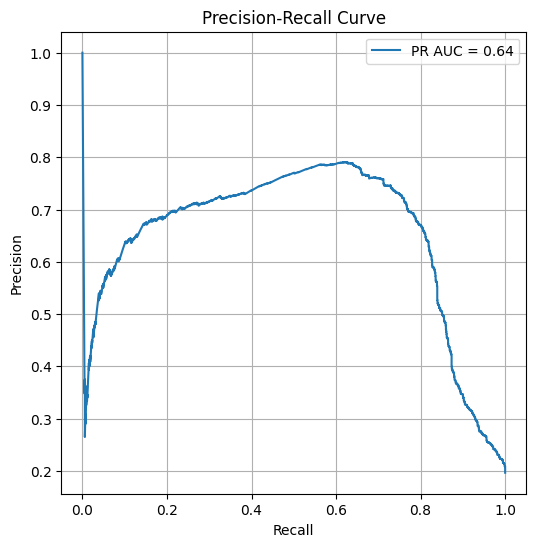

Best Threshold=0.605405, F2-Score=0.775


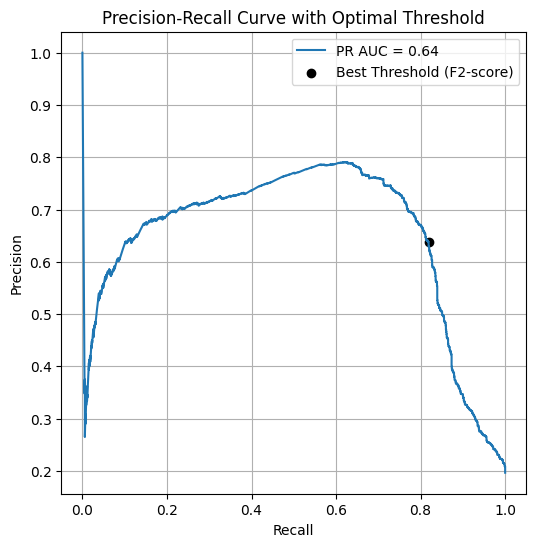

None

Testing starts here.......

Model testing on Training Data

The threshold is: 0.6054051518440247.

Confusion Matrix:
[[5671  726]
 [ 284 1279]]

Accuracy: 87.3 %
Recall: 0.818
F1 Score: 0.717
F2 Score: 0.774
Precision-Recall AUC (PRAUC): 0.644

Testing area for sample input data

Data shape: torch.Size([20, 23])

Number of training features: 23

Bagids shape: torch.Size([1, 20])

Construct data_df

Construct bagids_df

bagids_df shape is (20, 1).
data_df shape is (20, 23).
bagids_df column is Index(['MODEL_ID'], dtype='object').
data_df column is Index(['ADVERTISER_ID', 'TOTAL_CLICK', 'DEVICE', 'BROWSER',
       'UNIQUE_SESSION_NUM', 'UNIQUE_DAYS', 'TOTAL_TIME_ONSITE', 'TOTAL_SPEND',
       'AVG_SESSION_DURATION', 'REFERRAL_SOURCE', 'SITE_INTERACTION',
       'REFERRAL_SITE', 'MONDAYVISIT', 'TUESDAYVISIT', 'WEDNESDAYVISIT',
       'THURSDAYVISIT', 'FRIDAYVISIT', 'SATURDAYVISIT', 'SUNDAYVISIT',
       'MORNINGVISIT', 'DAYVISIT', 'EVENINGVISIT', 'NIGHTVISIT'],
      dtype='object')

In [36]:
    training_ratio = 4
    model_training = True
    if_store_model = False
    model_prediction = True
    AUDIENCE_LIMIT = 10000
    # Model setting
    n_neurons = 8
    lr = 1e-4
    n_epochs = 200
    batch_size = 20
    weight_decay = 0.001
    
    # Initialize LOOKALIKE_MODEL class correctly
    lookalike_model = LOOKALIKE_MODEL(
        training_ratio = training_ratio,   # 1-10 
        model_training = model_training,  
        if_store_model = if_store_model,   
        model_prediction = model_prediction,
        AUDIENCE_LIMIT = AUDIENCE_LIMIT,
        n_neurons = n_neurons,
        lr = lr,
        n_epochs = n_epochs,
        batch_size = batch_size,
        weight_decay = weight_decay
        
    )
    
    # Call the main method of LOOKALIKE_MODEL and get the response
    LOOKALIKE_MODEL_response = lookalike_model.main()
    
    LOOKALIKE_MODEL_response 
